# baseline 只MRI

In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import hiddenlayer as hl
import torch
import torch.nn as nn
from torch.optim import SGD,Adam
import torch.utils.data as Data
from torchvision import models
from  torchvision import transforms
from  torchvision.datasets import ImageFolder
import pickle as p
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
vgg16 = models.vgg16(pretrained=True)
#获取VGG16的特征提取层
vgg = vgg16.features
feature = list(vgg)[:30]
#获取VGG16的分类层
classify = vgg16.classifier
classifier = list(classify)

In [3]:
for layer in feature[:30]:
    for p in layer.parameters():
        p.requires_grad = False

In [4]:
vgg16_1 = nn.Sequential(*feature)

In [5]:
class MyVggModel(nn.Module):
    def __init__(self):
        super(MyVggModel,self).__init__()
        #预训练的Vgg16的特征提取层
        self.vgg = vgg16_1
        #添加新的全连接层
        self.classifier = nn.Sequential(
            nn.Linear(304128,512),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Dropout(p = 0.5),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,3)

        )

    #定义网络的前向传播
    def forward(self,x):
        x = self.vgg(x)
        x = x.view(x.size(0),-1)
        output = self.classifier(x)
        return output

In [6]:
Myvggc = MyVggModel()

In [7]:
Myvggc

MyVggModel(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation

In [8]:
#定义优化器
optimizer = torch.optim.Adam(Myvggc.parameters(),lr=0.00001)
loss_func = nn.CrossEntropyLoss()#损失函数

In [9]:
#记录训练过程指标
historyl = hl.History()
#使用Canves进行可视化

canvasl = hl.Canvas()

In [12]:
from torch.utils.data import DataLoader
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        super(MyDataset, self).__init__()
        MRI_PET_match_all = p.load(open(root,"rb"),encoding='iso-8859-1')
        MRI = []
        PET = []
        group = []
        for index,row in MRI_PET_match_all.iterrows():
            MRI.append(row['MRI_img_array'])
            PET.append(row['PET_img_array'])
            group.append(row['Group'])
        self.MRI = MRI
        self.PET = PET
        self.group = group  

    def __getitem__(self, index):
        mri =torch.from_numpy(self.MRI[index].transpose([2,0,1])).float().to(DEVICE)
        pet = self.PET[index]
        group = self.group[index]
        
        return mri,group

    def __len__(self):
        return len(self.MRI)

train_data = MyDataset("/home/gc/gechang/gec_multi_fusion/end_to_end/train.pkl")
test_data = MyDataset("/home/gc/gechang/gec_multi_fusion/end_to_end/test.pkl")

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64)


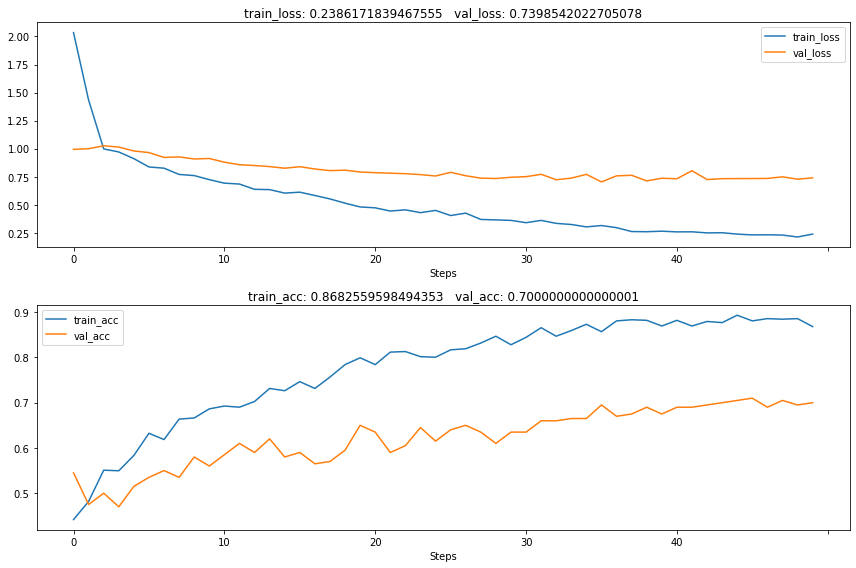

In [13]:
#对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(50):
    train_loss_epoch = 0
    val_loss_epoch = 0
    train_corrects = 0
    val_corrects = 0
    #对训练数据的加载器进行迭代计算
    Myvggc.train().cuda()
    for step,(b_x,b_y) in enumerate(train_loader):
        ##计算每个batch的损失
        output = Myvggc(b_x)
        loss = loss_func(output,b_y.to(DEVICE))#交叉熵损失函数
        pre_lab = torch.argmax(output,1).to(DEVICE)
        optimizer.zero_grad()#每个迭代步的梯度初始化为0
        loss.backward()#损失的后向传播，计算梯度
        optimizer.step()#使用梯度进行优化
        train_loss_epoch += loss.item()*b_x.size(0)
        train_corrects += torch.sum(pre_lab == b_y.to(DEVICE).data)
    #计算一个epoch的损失和精度
    train_loss = train_loss_epoch/len(train_data.group)
    train_acc = train_corrects.double()/len(train_data.group)
    print("epoch:",epoch,"loss:",train_loss,"acc:",train_acc)
     #计算在验证集上的表现
    Myvggc.eval()
    for step,(val_x,val_y) in enumerate(test_loader):
        output = Myvggc(val_x)
        loss = loss_func(output,val_y.to(DEVICE))
        pre_lab = torch.argmax(output,1).to(DEVICE)
        val_loss_epoch += loss.item()*val_x.size(0)
        val_corrects += torch.sum(pre_lab == val_y.to(DEVICE).data)

    #计算一个epoch上的输出loss和acc
    val_loss = val_loss_epoch/len(test_data.group)
    val_acc = val_corrects.double()/len(test_data.group)
    #保存每个epoch上的输出loss和acc
    historyl.log(epoch,train_loss=train_loss,val_loss = val_loss,train_acc = train_acc.item(),val_acc = val_acc.item())
    #可视化网络训练的过程
    with canvasl:
        canvasl.draw_plot([historyl["train_loss"],historyl["val_loss"]])
        canvasl.draw_plot([historyl["train_acc"],historyl["val_acc"]])
